# Imports

In [22]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io.arff import loadarff
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Helper functions

In [20]:
# função para adicionar as métricas de um fold em um dicionário
def dic_par_metrics(y_test, y_onehot_test, y_pred, y_proba, grid_search_cv):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred)
    precision_micro = metrics.precision_score(y_test, y_pred, average='micro')
    precision_macro = metrics.precision_score(y_test, y_pred, average='macro')
    precision_weighted = metrics.precision_score(y_test, y_pred, average='weighted')
    recall_micro = metrics.recall_score(y_test, y_pred, average='micro')
    recall_macro = metrics.recall_score(y_test, y_pred, average='macro')
    recall_weighted = metrics.recall_score(y_test, y_pred, average='weighted')
    f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
    f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
    f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted')
    roc_auc_ovr_micro = metrics.roc_auc_score(y_onehot_test, y_proba, multi_class='ovr', average='micro')
    roc_auc_ovo_micro = metrics.roc_auc_score(y_onehot_test, y_proba, multi_class='ovo', average='micro')
    roc_auc_ovr_macro = metrics.roc_auc_score(y_onehot_test, y_proba, multi_class='ovr', average='macro')
    roc_auc_ovo_macro = metrics.roc_auc_score(y_onehot_test, y_proba, multi_class='ovo', average='macro')
    roc_auc_ovr_weighted = metrics.roc_auc_score(y_onehot_test, y_proba, multi_class='ovr', average='weighted')
    roc_auc_ovo_weighted = metrics.roc_auc_score(y_onehot_test, y_proba, multi_class='ovo', average='weighted')
    dicMetricas = {
        "parameters": grid_search_cv.best_params_,
        "metrics":{
            "accuracy": accuracy,
            "balanced_accuracy": balanced_accuracy,
            "precision_micro": precision_micro,
            "precision_macro": precision_macro,
            "precision_weighted": precision_weighted,
            "recall_micro": recall_micro,
            "recall_macro": recall_macro,
            "recall_weighted": recall_weighted,
            "f1_micro": f1_micro,
            "f1_macro": f1_macro,
            "f1_weighted": f1_weighted,
            "roc_auc_ovr_micro": roc_auc_ovr_micro,
            "roc_auc_ovo_micro": roc_auc_ovo_micro,
            "roc_auc_ovr_macro": roc_auc_ovr_macro,
            "roc_auc_ovo_macro": roc_auc_ovo_macro,
            "roc_auc_ovr_weighted": roc_auc_ovr_weighted,
            "roc_auc_ovo_weighted": roc_auc_ovo_weighted
        }
    }
    return dicMetricas

In [4]:
# função para calcular a média das métricas de todos os folds
def calc_mean(dic_json):
    key = list(dic_json.keys())[0]
    dic_mean = {}
    for j in dic_json[key]['metrics'].keys():
        sum_metric = 0
        for i in dic_json.keys():
            sum_metric+=dic_json[i]['metrics'][j]
        mean = sum_metric/len(dic_json.keys())
        dic_mean.update({j: mean})
    return dic_mean

In [5]:
def plot_matriz_confusao_one_vs_one(y_test, y_pred, model_name, fold_i, flag_normalizado="true"):
    """Plota a matriz de confusao comparando cada classe entre si, mostrando as predicoes contra as
    classes verdadeiras.

    Args:
        y_test: serie com os valores verdadeiros
        y_pred: serie com os valores preditos
        flag_normalizado (optional): flag indicando se os valores da matriz de confusao devem ser
        normalizados. Se devem ser normalizados pel. Defaults to None.
    """
    class_names = np.unique(y_pred)

    fig, ax = plt.subplots(figsize=(12, 10))
    cm_plot = metrics.ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, cmap="YlOrRd", normalize=flag_normalizado, ax=ax)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_title(f"Matriz de Confusao - Modelo {model_name} - Fold {fold_i}")

    cm_plot.figure_.savefig(
        f"imgs/{model_name}/cm_normalizado_{flag_normalizado}_{model_name}_fold_{fold_i}.png", 
        dpi=300
    )
    plt.close()
    
    return cm_plot

In [6]:
def inicializa_roc_one_class_vs_rest_kfold(y_onehot_test, y_pred_score, i, class_id, ax, tprs, aucs, mean_fpr):
    viz = metrics.RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_pred_score[:, class_id],
        name=f"ROC OvR Class_{class_id+1} fold {i}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(i==9),
    )

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

In [7]:
def gera_roc_one_class_vs_rest_kfold(tprs, aucs, mean_fpr, plot, model_name, class_id):
    fig = plot[0]
    ax = plot[1]
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Curva ROC media com desvio padrao\nROC OvR Class_{class_id+1}",
    )
    ax.axis("square")
    ax.legend(loc="lower right")

    fig.savefig(f"imgs/{model_name}/roc_{model_name}_class_{class_id+1}.png", dpi=300)
    plt.close()

In [8]:
def inicializa_roc_micro_average_kfold(y_onehot_test, y_pred_score, i, ax, tprs, aucs, mean_fpr):
    viz = metrics.RocCurveDisplay.from_predictions(
        y_onehot_test.ravel(),
        y_pred_score.ravel(),
        name=f"micro-average OvR fold {i}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(i==9)
    )

    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

In [9]:
def gera_roc_micro_average_kfold(tprs, aucs, mean_fpr, fig, ax, model_name):
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )
    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Curva ROC media com desvio padrao\nROC micro-average",
    )
    ax.axis("square")
    ax.legend(loc="lower right")

    fig.savefig(f"imgs/{model_name}/roc_micro_average_{model_name}.png", dpi=300)
    plt.close()

In [24]:
def stratified_k_fold_grid_search_cv(model, params:dict, X, y, model_name):
    """Realiza o treino e validacao do modelo utilizando StratifiedKFold com GridSearchCV para
    busca dos melhores hiperparametros (tendo assim um nested cross-validation).

    Args:
        model: modelo que se deseja treinar e validar
        params (dict): dicionario com os parametros e seus respectivos valores possiveis para o 
        grid search
        X: features do modelo
        y: coluna de target do modelo
    """
    print(f"Modelo: {model_name}")
    dic_json = {}

    n_splits_k_fold = 10
    n_splits_grid_search = 5

    matriz_tprs = [[] for i in range(9)]
    matriz_aucs = [[] for i in range(9)]
    mean_fpr = np.linspace(0, 1, 100)
    lista_plots = [plt.subplots(figsize=(6, 6)) for i in range(9)]

    tprs_micro_average = []
    aucs_micro_average = []
    fig_micro_average, ax_micro_average = plt.subplots(figsize=(6, 6))

    skf = StratifiedKFold(n_splits=n_splits_k_fold, random_state=4, shuffle=True)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"## INICIO FOLD {i} ##")
        # separa os dados de treino e teste
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        # normaliza os dados
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # binariza a coluna target para uso no plot roc e metrica roc_auc_score
        label_binarizer = LabelBinarizer().fit(y_train)
        y_onehot_test = label_binarizer.transform(y_test)
        # prepara o y_train
        y_train = y_train.values.ravel()
        # inicializa e roda o grid search
        grid_search_cv = GridSearchCV(
            estimator=model, param_grid=params, scoring="f1_weighted", cv=n_splits_grid_search, 
            verbose=3)
        grid_search_cv.fit(X_train, y_train)
        # com os melhores parametros encontrados, realiza a predicao no fold de teste e calcula a 
        # metrica de avaliacao
        y_pred = grid_search_cv.predict(X_test)
        y_proba = grid_search_cv.predict_proba(X_test)
        # armazenando as metricas e os parametros em um dicionario
        dic_fold = dic_par_metrics(y_test, y_onehot_test, y_pred, y_proba, grid_search_cv)
        dic_json.update({"fold "+str(i): dic_fold})
        # gera a matriz de confusao com dados normalizados e nao normalizados e salva ambas versoes
        plot_matriz_confusao_one_vs_one(y_test, y_pred, model_name, i, flag_normalizado="true")
        plot_matriz_confusao_one_vs_one(y_test, y_pred, model_name, i, flag_normalizado=None)
        # inicializa a curva roc para cada classe neste fold
        for class_id, plot, tprs, aucs in zip(range(9), lista_plots, matriz_tprs, matriz_aucs):
            inicializa_roc_one_class_vs_rest_kfold(
                y_onehot_test, y_proba, i, class_id, plot[1], tprs, aucs, mean_fpr
            )
        # inicializa a curva roc micro average neste fold
        inicializa_roc_micro_average_kfold(
            y_onehot_test, y_proba, i, ax_micro_average, tprs_micro_average, 
            aucs_micro_average, mean_fpr
        )
        print(f"## FINAL FOLD {i} ##\n", dic_fold)

    # inserindo a média dos folds no dicionário
    dic_json.update({"mean": calc_mean(dic_json)})
    # salvando o dicionário no formato json
    objOpen = open(f'./log_metrics/{model_name}.json', 'w')
    objOpen.write(json.dumps(dic_json, indent=4))
    objOpen.close()

    # gera o plot da curva roc para cada classe, juntando todos os folds e realizando uma media
    for class_id, plot, tprs, aucs in zip(range(9), lista_plots, matriz_tprs, matriz_aucs):
        gera_roc_one_class_vs_rest_kfold(tprs, aucs, mean_fpr, plot, model_name, class_id)
    # gera o plot da curva roc micro average, juntando todos os folds e realizando uma media 
    gera_roc_micro_average_kfold(
        tprs_micro_average, aucs_micro_average, mean_fpr, fig_micro_average, ax_micro_average, 
        model_name
    )

# Carrega dados

In [11]:
raw_data = loadarff('data/dataset.arff')
df_data = pd.DataFrame(raw_data[0])
df_data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,11.0,0.0,1.0,1.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
3,4.0,1.0,0.0,0.0,1.0,6.0,1.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,2.0,2.0,0.0,0.0,0.0,58.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,3.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,22.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,b'Class_1'
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,b'Class_1'


In [12]:
# decodifica string de target
df_data["target"] = df_data["target"].str.decode("utf-8")

In [13]:
df_data.sample(5)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
31745,31746.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_6
41371,41372.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Class_6
61830,61831.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_9
41845,41846.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,6.0,2.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Class_6
5848,5849.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,Class_2


In [14]:
# verifica dimensoes do banco de dados
df_data.shape

(61878, 95)

In [15]:
# verifica se possuem colunas com dados nulos
df_data.isnull().sum()

id         0
feat_1     0
feat_2     0
feat_3     0
feat_4     0
feat_5     0
feat_6     0
feat_7     0
feat_8     0
feat_9     0
feat_10    0
feat_11    0
feat_12    0
feat_13    0
feat_14    0
feat_15    0
feat_16    0
feat_17    0
feat_18    0
feat_19    0
feat_20    0
feat_21    0
feat_22    0
feat_23    0
feat_24    0
feat_25    0
feat_26    0
feat_27    0
feat_28    0
feat_29    0
feat_30    0
feat_31    0
feat_32    0
feat_33    0
feat_34    0
feat_35    0
feat_36    0
feat_37    0
feat_38    0
feat_39    0
feat_40    0
feat_41    0
feat_42    0
feat_43    0
feat_44    0
feat_45    0
feat_46    0
feat_47    0
feat_48    0
feat_49    0
feat_50    0
feat_51    0
feat_52    0
feat_53    0
feat_54    0
feat_55    0
feat_56    0
feat_57    0
feat_58    0
feat_59    0
feat_60    0
feat_61    0
feat_62    0
feat_63    0
feat_64    0
feat_65    0
feat_66    0
feat_67    0
feat_68    0
feat_69    0
feat_70    0
feat_71    0
feat_72    0
feat_73    0
feat_74    0
feat_75    0
feat_76    0

In [16]:
# verifica distribuicao das classes nas instancias do banco de dados
df_data["target"].value_counts()

target
Class_2    16122
Class_6    14135
Class_8     8464
Class_3     8004
Class_9     4955
Class_7     2839
Class_5     2739
Class_4     2691
Class_1     1929
Name: count, dtype: int64

In [17]:
df_data.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,feat_50,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,feat_65,feat_66,feat_67,feat_68,feat_69,feat_70,feat_71,feat_72,feat_73,feat_74,feat_75,feat_76,feat_77,feat_78,feat_79,feat_80,feat_81,feat_82,feat_83,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,0.263906,1.252869,0.140874,0.480979,1.696693,1.284398,1.413459,0.366108,0.575423,0.551699,0.471525,0.204014,0.729969,0.142522,2.643880,1.534520,0.563108,0.696613,0.238970,0.275768,0.150312,0.148680,1.043796,0.696516,0.946411,0.666263,0.709089,0.263632,0.582129,0.485585,1.653059,0.303468,0.698019,0.451146,0.560829,0.238130,0.641375,0.249669,1.584893,0.348314,0.324283,0.053298,0.213485,0.442063,2.072465,0.323120,0.303775,0.309108,0.697970,0.388603,1.029930,0.239746,1.187563,0.168590,1.256796,0.222228,0.571706,2.897653,0.392902,0.811128,0.892789,0.319290,0.858722,0.591050,0.579851,0.726817,0.748457,0.124196,0.366415,0.300446,0.698067,0.078461,0.187983,0.496719,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,1.083340,3.042333,0.567089,2.014697,3.163212,3.862236,2.226163,1.477436,1.335985,4.636145,1.438727,0.696050,1.446220,0.782979,4.629015,2.332994,1.710305,2.873222,0.828112,1.901294,1.640880,0.897354,2.416849,1.310202,3.368622,3.197965,2.555119,0.756934,1.602579,3.298315,3.299798,1.085672,1.961189,1.706013,1.346090,2.587131,2.348359,1.446203,2.577071,1.369380,1.720470,0.513820,1.044788,2.006485,4.113319,0.998743,1.925806,1.082148,3.983722,2.577693,3.028469,1.017553,2.666742,0.946158,3.402080,0.783052,1.361874,4.974322,1.761054,4.111091,1.941368,1.162443,2.411646,5.783233,3.757822,3.200095,2.920038,0.906621,2.778317,1.285569,2.245671,0.461244,0.836269,2.434921,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

# Modelos

-> knn, decision tree, random forest, naive bayes

-> regressao logistica, perceptron, mlp
svm

In [18]:
X = df_data.drop(columns=["id", "target"])
y = df_data[["target"]]

## KNN

Modelo: KNN
## INICIO FOLD 0 ##
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .....................n_neighbors=5;, score=0.756 total time=   4.3s
[CV 2/5] END .....................n_neighbors=5;, score=0.762 total time=   4.2s
[CV 3/5] END .....................n_neighbors=5;, score=0.756 total time=   4.6s
[CV 4/5] END .....................n_neighbors=5;, score=0.766 total time=   4.6s
[CV 5/5] END .....................n_neighbors=5;, score=0.761 total time=   4.0s
[CV 1/5] END ....................n_neighbors=10;, score=0.755 total time=   4.1s
[CV 2/5] END ....................n_neighbors=10;, score=0.760 total time=   4.8s
[CV 3/5] END ....................n_neighbors=10;, score=0.753 total time=   3.9s
[CV 4/5] END ....................n_neighbors=10;, score=0.761 total time=   3.9s
[CV 5/5] END ....................n_neighbors=10;, score=0.755 total time=   4.4s
[CV 1/5] END ....................n_neighbors=15;, score=0.750 total time=   4.2s
[CV 2/5] END ....

KeyboardInterrupt: 

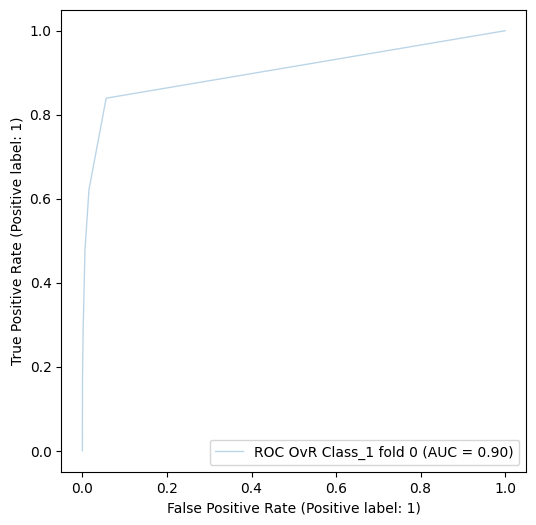

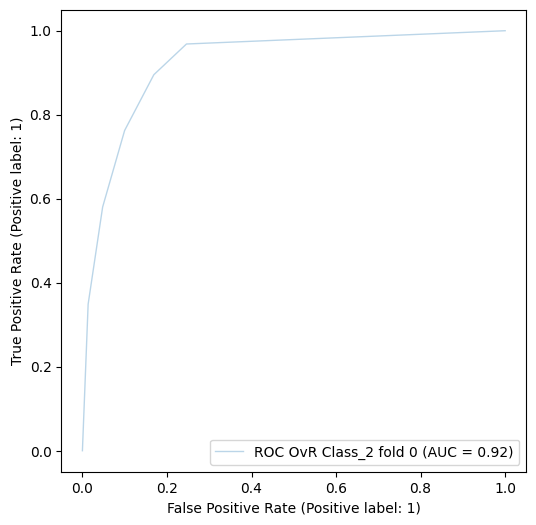

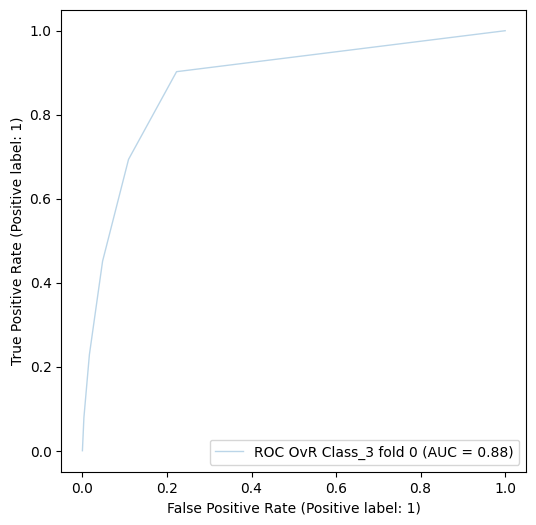

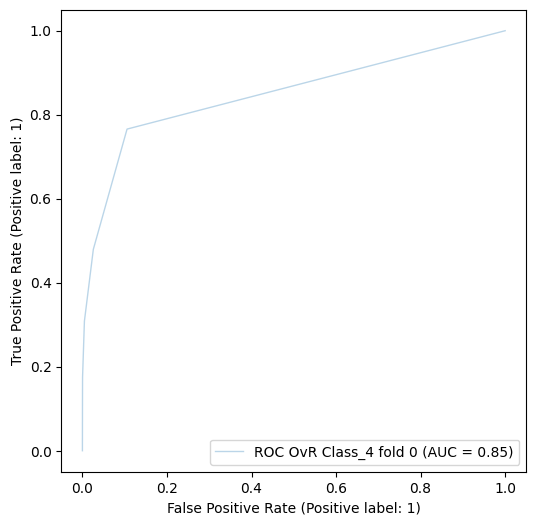

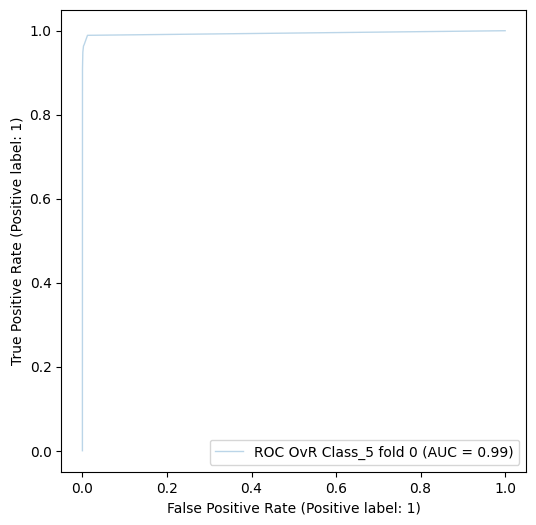

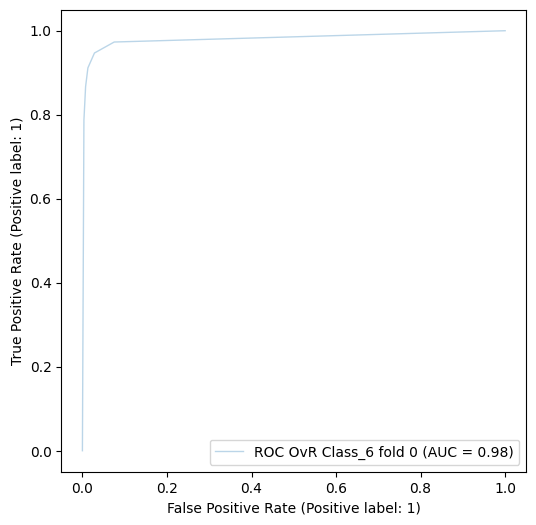

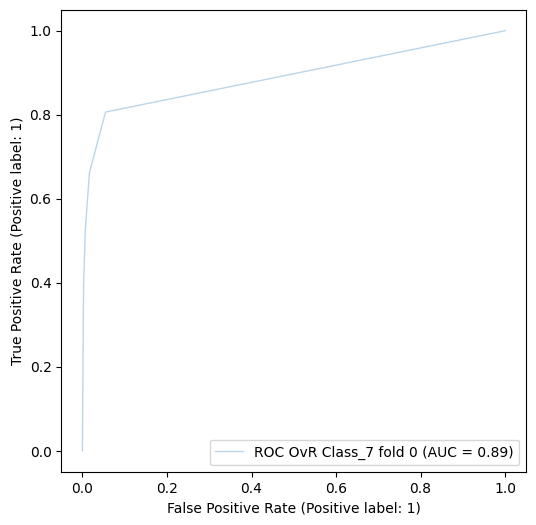

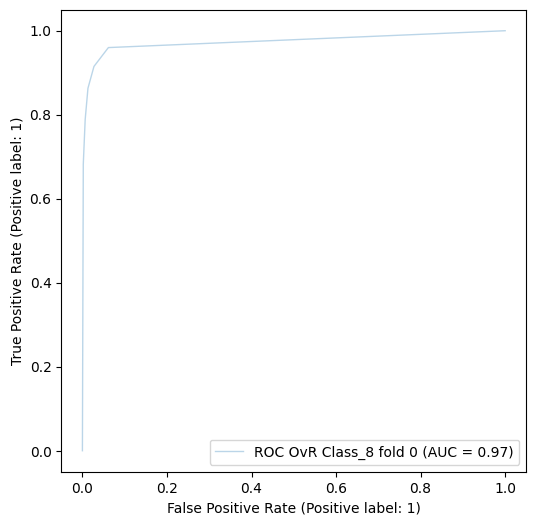

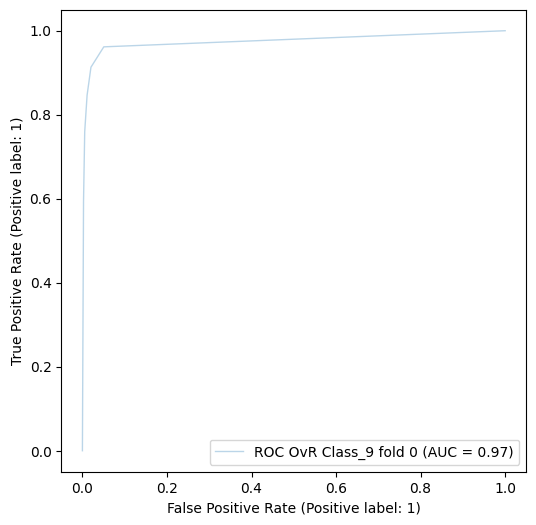

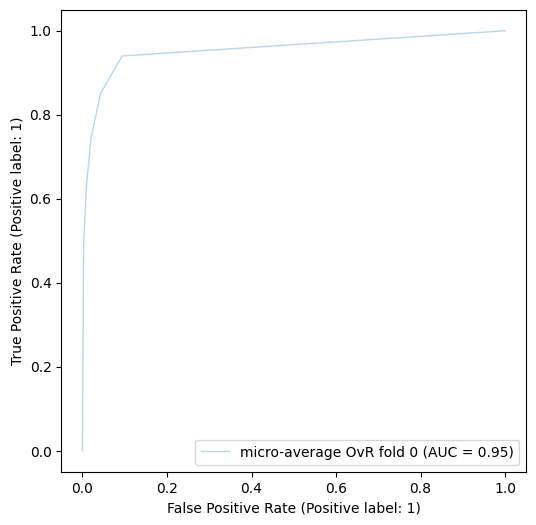

In [25]:
# define os parametros e seus respectivos valores a serem testados no grid search
params = {
    "n_neighbors": [5, 10, 15]
}
# define o modelo
model = KNeighborsClassifier(n_jobs=1)
# chama a funcao que roda o stratified k fold e valida o modelo realizando a busca por hiper 
# parametros com grid search cv, fazendo assim um nested cross-validation
stratified_k_fold_grid_search_cv(model, params, X, y, "KNN")

## DecisionTree

Modelo: DecisionTree
## INICIO FOLD 0 ##
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END class_weight=balanced, criterion=gini;, score=0.699 total time=   2.8s
[CV 2/5] END class_weight=balanced, criterion=gini;, score=0.696 total time=   2.8s
[CV 3/5] END class_weight=balanced, criterion=gini;, score=0.698 total time=   3.1s
[CV 4/5] END class_weight=balanced, criterion=gini;, score=0.707 total time=   4.0s
[CV 5/5] END class_weight=balanced, criterion=gini;, score=0.701 total time=   2.4s
[CV 1/5] END class_weight=balanced, criterion=entropy;, score=0.690 total time=   2.5s
[CV 2/5] END class_weight=balanced, criterion=entropy;, score=0.701 total time=   3.3s
[CV 3/5] END class_weight=balanced, criterion=entropy;, score=0.699 total time=   2.6s
[CV 4/5] END class_weight=balanced, criterion=entropy;, score=0.696 total time=   2.9s


KeyboardInterrupt: 

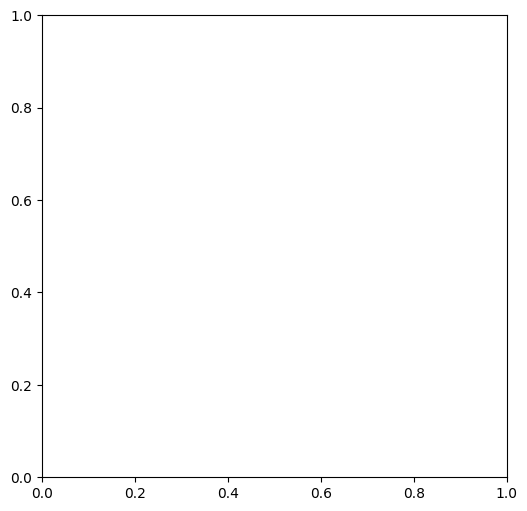

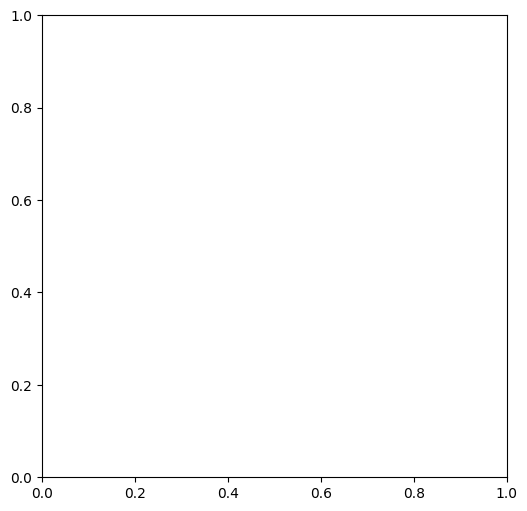

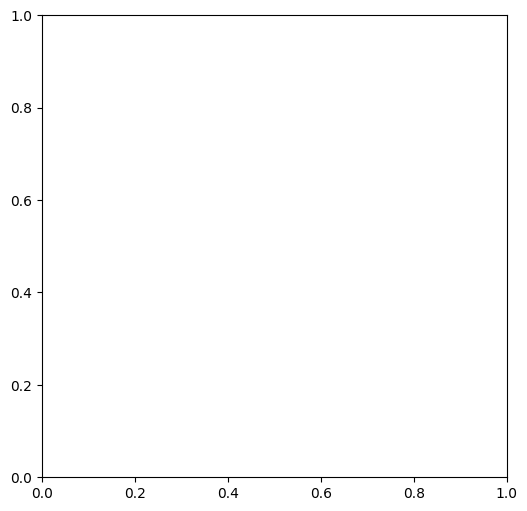

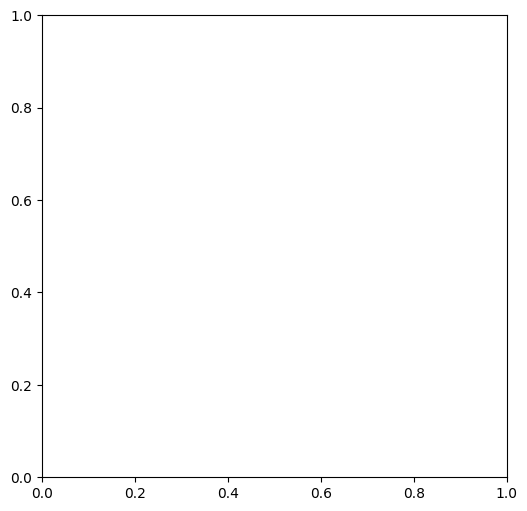

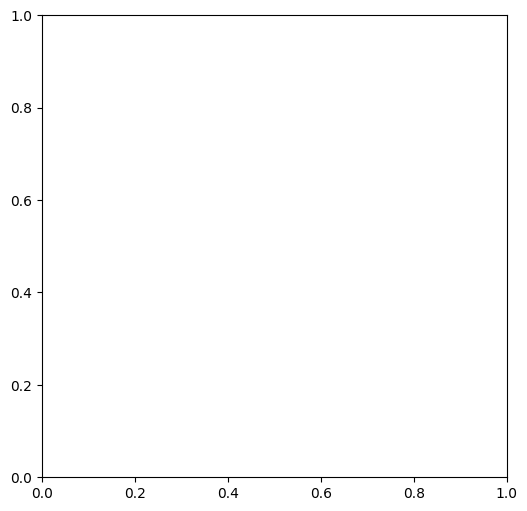

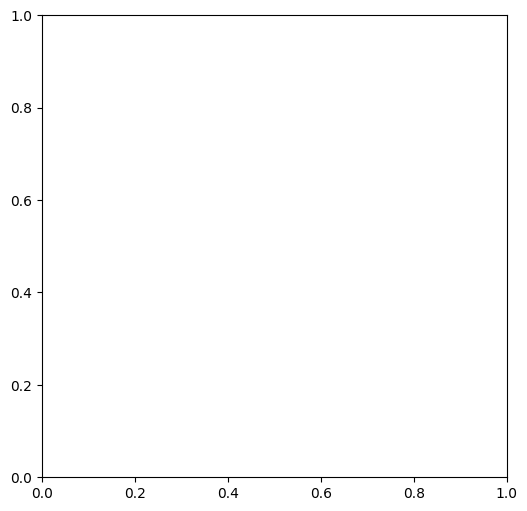

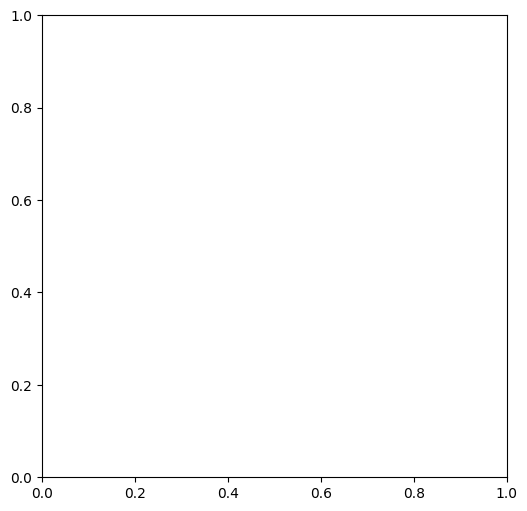

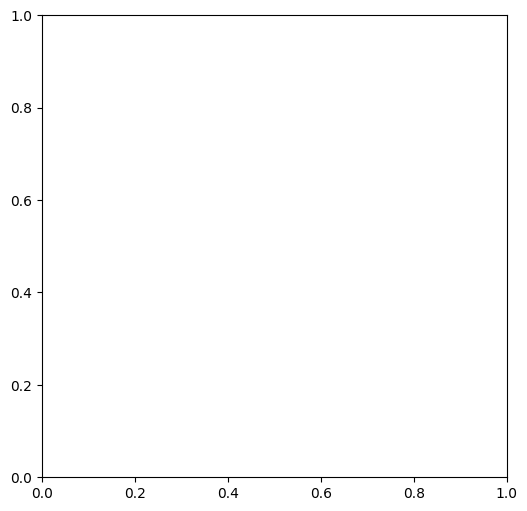

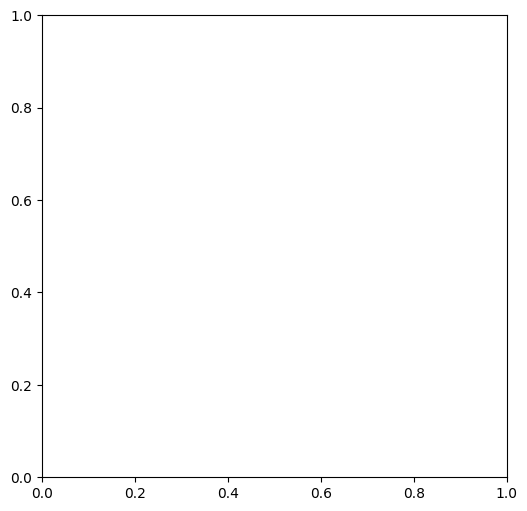

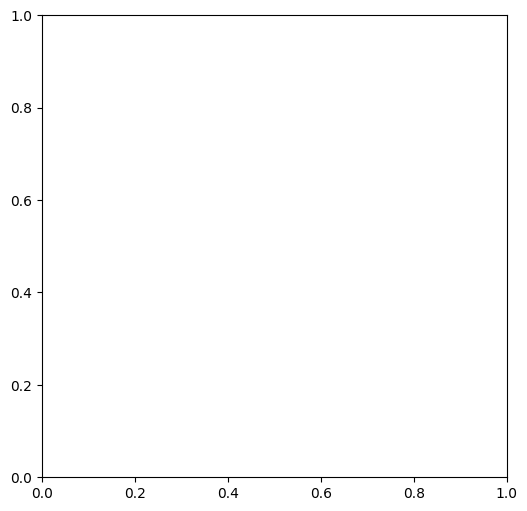

In [26]:
# define os parametros e seus respectivos valores a serem testados no grid search
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "class_weight": ["balanced", None]
}
# define o modelo
model = DecisionTreeClassifier(random_state=4)
# chama a funcao que roda o stratified k fold e valida o modelo realizando a busca por hiper 
# parametros com grid search cv, fazendo assim um nested cross-validation
stratified_k_fold_grid_search_cv(model, params, X, y, "DecisionTree")

In [ ]:
# define os parametros e seus respectivos valores a serem testados no grid search
params = {
    "max_iter": [100, "entropy", "log_loss"],
    "class_weight": ["balanced", None]
}
# define o modelo
model = LogisticRegression(random_state=4)
# chama a funcao que roda o stratified k fold e valida o modelo realizando a busca por hiper 
# parametros com grid search cv, fazendo assim um nested cross-validation
stratified_k_fold_grid_search_cv(model, params, X, y, "LogisticRegression")

# Extra

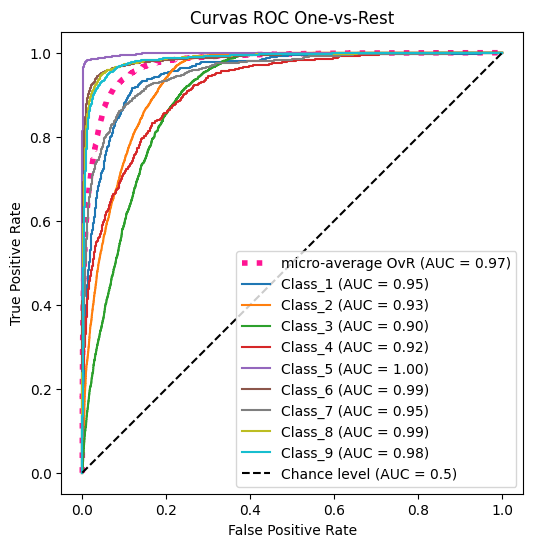

In [121]:
# PLOT NAO UTILIZADO NO PROJETO, REFERENCIA PARA USO FUTURO
# # store the fpr, tpr, and roc_auc for all averaging strategies
# fpr, tpr, roc_auc = dict(), dict(), dict()
# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_pred_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# list_colors = [
#     "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:gray", 
#     "tab:olive", "tab:cyan"
# ]

# fig, ax = plt.subplots(figsize=(6, 6))

# plt.plot(
#     fpr["micro"],
#     tpr["micro"],
#     label=f"micro-average OvR (AUC = {roc_auc['micro']:.2f})",
#     color="deeppink",
#     linestyle=":",
#     linewidth=4,
# )

# #colors = cycle(["aqua", "darkorange", "cornflowerblue"])
# for class_id, color in zip(range(9), list_colors):
#     RocCurveDisplay.from_predictions(
#         y_onehot_test[:, class_id],
#         y_pred_score[:, class_id],
#         name=f"Class_{class_id+1}",
#         color=color,
#         ax=ax,
#         plot_chance_level=(class_id==8)
#     )

# plt.axis("square")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Curvas ROC One-vs-Rest")
# plt.legend()
# plt.show()